<img src="./assets/Daraz-Symbol.png" alt="Logo" style="float:left;width:100px;"/>

# Daraz SmartPhone section Scraper

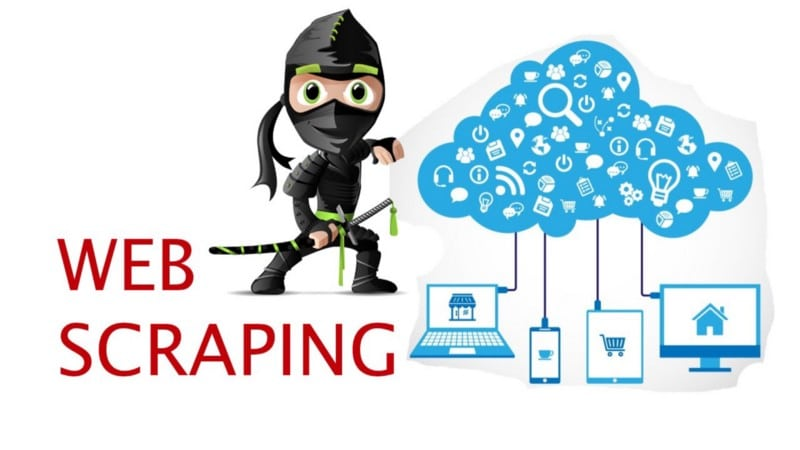

A web scraper is a software tool or program that automates the process of extracting data from websites. It works by sending automated requests to a website, parsing the HTML code of the site, and extracting relevant data based on specific rules or patterns.

Web scraping can be used for various purposes, such as collecting data for research, monitoring online prices, extracting product information for e-commerce, and aggregating news articles. 

:exclamation: However, it's important to note that web scraping may be illegal or against a website's terms of service, so it's crucial to be aware of the legal and ethical implications of using such tools.

We are going to scrap information from daraz.com.np/smartphones section.

:pushpin: Tips: while scraping website, don't be rigid to extract those information that you are going to use, insted try to be more flexible to scrap maximum information which might going to come handy later.

## Table of content

- [problem statement](#problem_statement)
- [flow chart](#flow_chart)
- [challanges](#challanges)
- [limitations](#limitations)
- [Import libraries](#import_libraries)
- [scrape product listing page](#product_listing)
    - [Helper functions](#helper_functions) 
- [scrape product detail page](#product_detail)
- [Run scraper concurrently](#run_concurrently)
- [Run the scraper](#run)
- [Save the data](#save)


# <a name="problem_statement"></a> Problem Statement
- To build a knowledge graph from smartphone information, we need to have data. So, the first step is to build a scraper to scrape smartphone information from one of the biggest eCommerce site of Nepal i.e daraz.com.np

This knowledge graph can be used for business decision making, to build recommendation engine or knowledge base for a chat bot and so on. 

## <a name="flow_chart"></a>Flow Chart

Upon analyzing the daraz/smartphone section, it was found that we can send direct API requestion to get the json data of product listing page, it means we don't have to spend extract effort to parse the required content from HTML document using beautiful soup. However, we need to extract interested information from the json but with less effort.

product listing page = 1 API example: https://www.daraz.com.np/smartphones/?page=1&ajax=true

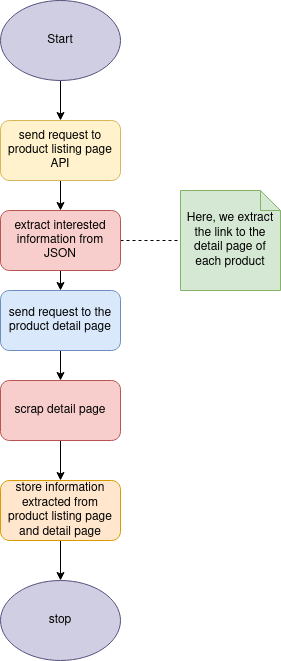

# <a name="challanges"></a> Challanges

Unlike scraping static website or some news portal, scraping daraz.com.np is quite challanging because of the following reasons:
- It has bot detection mechanism, thus can not send unlimited request continuously
- Scraping product listing page is straight forward, since we have an end-point API to get the json data. But to scrape product detail page we have to search for the data into the html doc whether it is available in already rendered form or in a JSON string within html response.
- If you check out the product detail page, you will find that their "price" is dynamic with respect to "storage capacity" and "RAM". We need to capture that information also, which is another big challange.   


# <a name="limitations"></a> Limitations

- We can not make a single scraper that can scrape every category of items from daraz such as electronics, foods, clothes etc. However they might have something in common such as their API structure, their page structure, and so on. But building a single generic scraper is not possible to scrape the unstructured information from multiple categories.  

# <a name="import_libraries"></a> Import Libraries
Let's import some libraries that we are going to use to create web scraper and to parse and filter the contents.

In [57]:
# to scrap the web page
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from concurrent.futures import ThreadPoolExecutor
import time

# helper libraries that use are going to use while parsing the contents into structured form.
import json # to load and save json file 
import difflib
import re

# <a name="product_listing"></a> Scrape product listing page
A product listing page is a webpage on an e-commerce website that displays a list of products for sale. It typically includes product images, names, descriptions, prices, and other relevant information such as ratings and reviews.

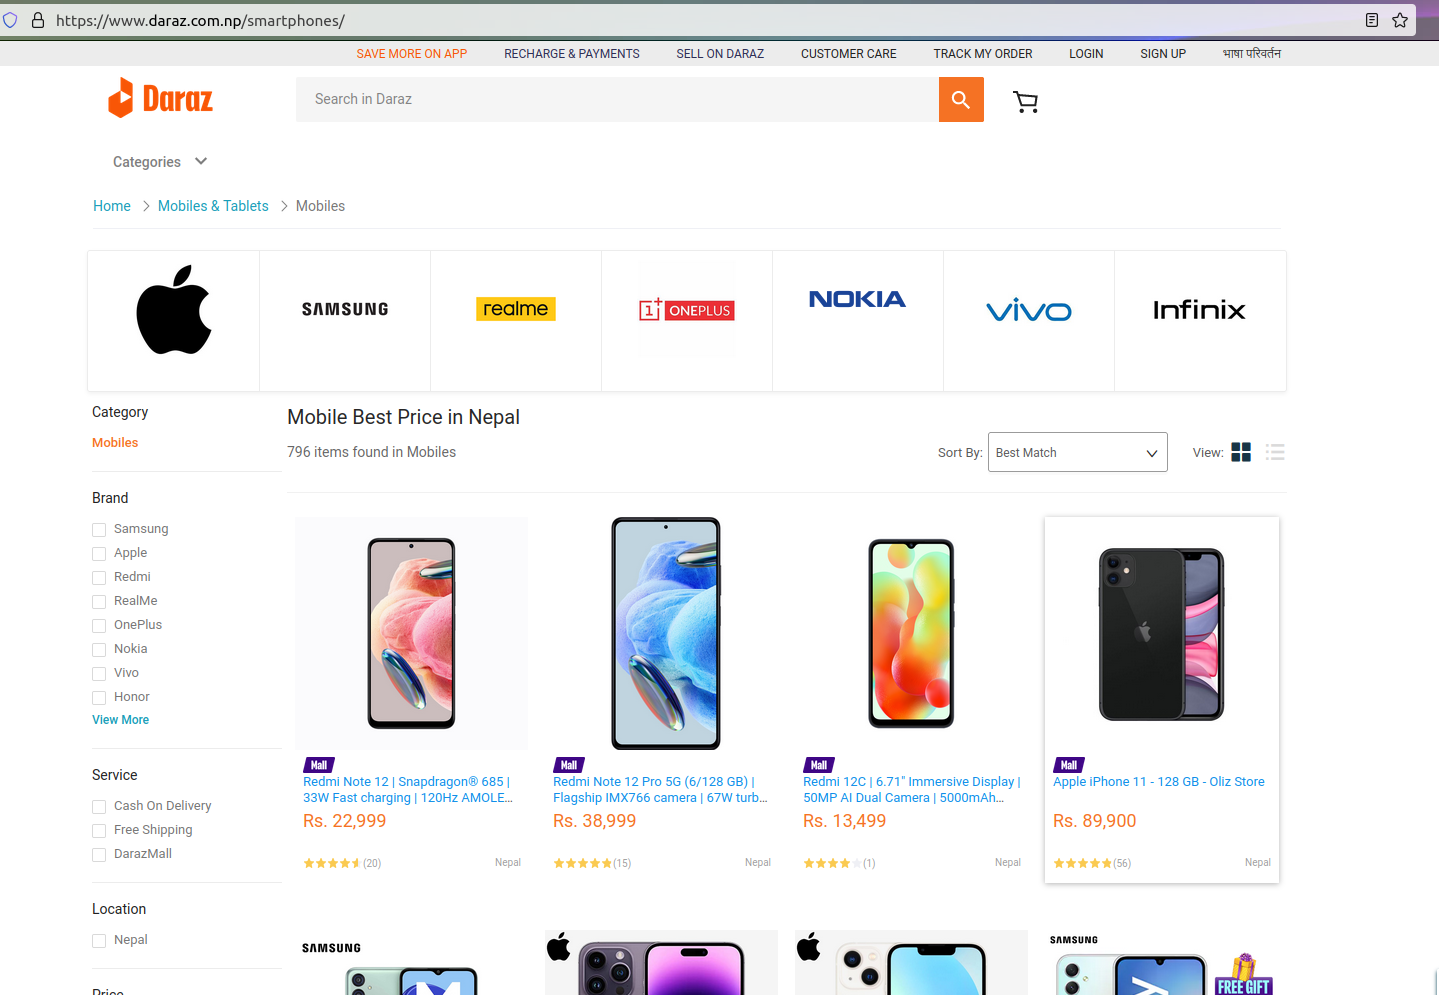
**figure: screenshot of product listing page**


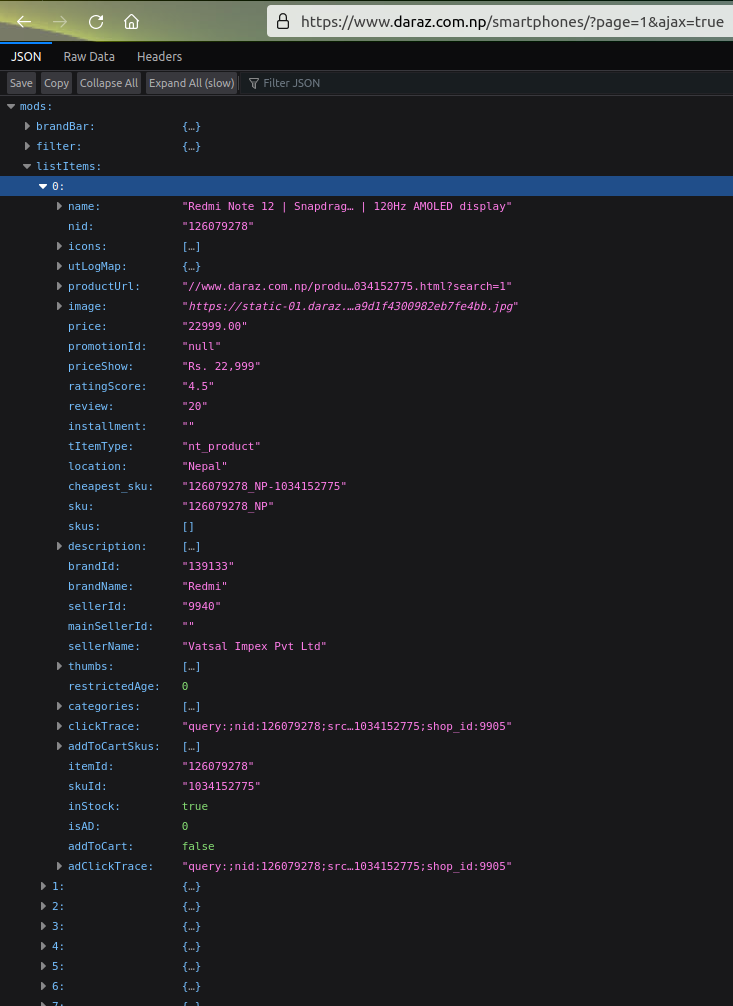
**figure: screenshot of product list page API response**

## <a name="helper_functions"></a> Helper functions 
- to parse interested information from product listing page

In [58]:
def parse_description(description:list):
    '''
    description is a list of product description (unstructured data), 
    thus we are going to carefully scrap the description inorder to make it structured
    
    args: 
        description: list of string
    returns:
        output: dict object
        
    example:
        >> description = ["Display: 6.67&quot; AMOLED DotDisplay", 
                        "Refresh rate: 120Hz", "Battery: 5000mAh (typ)"]
        >> parse_description(description)
        {'display': [['6.67&quot; amoled dotdisplay']], 'battery': [['5000mah (typ)']]}
    '''
    
    DESCRIPTIONS = ['processor', 'display', 'os', 'battery', 'rear camera']
    # clean up from description strings
    desc_dict = {}
    for desc in description:
        desc_item = desc.split(':')
        if len(desc_item) < 2:
            continue
        desc_dict[desc_item[0].lower()] = [list(map(lambda x: x.strip(),
                                                    desc.strip().lower().split(','))) 
                                           for desc in desc_item[1:]]

    desc_keys = desc_dict.keys() 
    #generate output
    output = {}
    for desc in DESCRIPTIONS:
        # here we are using difflib to find the close matched; 
        # with this we can handle spelling mistakes 
        # or slightly different spelling of the same description
        close_match = difflib.get_close_matches(desc, desc_keys)
        if not close_match:
            continue
        output[desc] = desc_dict[close_match[0]] 
    return output


def create_product_detail_link(product_url):
    '''
     add https at the beginning of raw product url
     
     args:
         product_url : string
     returns:
         url: string with https: at the beginnig of the product_url
    '''
    return 'https:'+product_url


def filter_product_data(product:dict):
    '''
    extract only the selected items from product dictionary
    args:
        product: dict
    returns:
        dict object
    '''
    # here are are going to extract, produt's name, 
    # url to the detail page, rating, review, brand_name, brand_id,
    # seller_name, and description
    
    # note that other information such as price, RAM, storage 
    # and other description can be extracted from the detail page
    return {
        # extract product name
        'name': product['name'],
        # extract product url
        'url': create_product_detail_link(product['productUrl']),
        # rating
        'rating': float(product.get('ratingScore', 0)),
        # review
        'review': float(product.get('review', 0)),
        'brand_name': product['brandName'],
        'brand_id': product['brandId'],
        'seller_name': product['sellerName'],
        'description': parse_description(product['description'])
    }


def parse_product_json(product_json:list):
    '''
    extract the interested information of each product from list of products
    
    args:
        product_json : list of dict; contains list of products data which is 
                        a "listItem" value of the API data
    
    returns:    
        list of filtered data
    '''

    output = []
    for product in product_json:
        output.append(filter_product_data(product))
    return output



def scrape_single_page(url):
    '''
        scrap the product listing page of the given url and the detail page of each product; 
        it simply scraps the information of each product available at the listing page, 
        and by heading one step deeper, it scraps the information available in detail page of each product  
        
        args:
            url: string; API of product listing page of a particular page number
        
        returns:
            prased data
    '''
    
    print("******scraping:****", url)
    
    global session
    response = session.get(url)
#     cookies = response.cookies
#     session.cookies.update(cookies)
    if response.status_code != 200:
        print(f"error code {response.status_code}: {url}")
        return None
    
    product_json = json.loads(response.text)['mods']['listItems']
    products_data = parse_product_json(product_json)
    
    # scrap data from detail page and update product
    print("extracting products detail")
    for count, product in enumerate(products_data):
        print("product:", product['url'])
        product_detail_data = {
            'details': scrape_product_details(product['url'])
        }
        product.update(product_detail_data)
        
        # we need to hold the scraping process for some time
        # it is unethical to give continuous load to the same server
        # as well as if we send 10s of requests continuously daraz will detect us the temporarily block us
        time.sleep(5)
    
    return products_data

# <a name="product_detail"></a> Scrape product detail Page
A product detail page (PDP) is a webpage on an e-commerce website that provides detailed information about a specific product. The page typically includes product images, a detailed product description, pricing information, customer reviews and ratings, shipping options, and other relevant information.

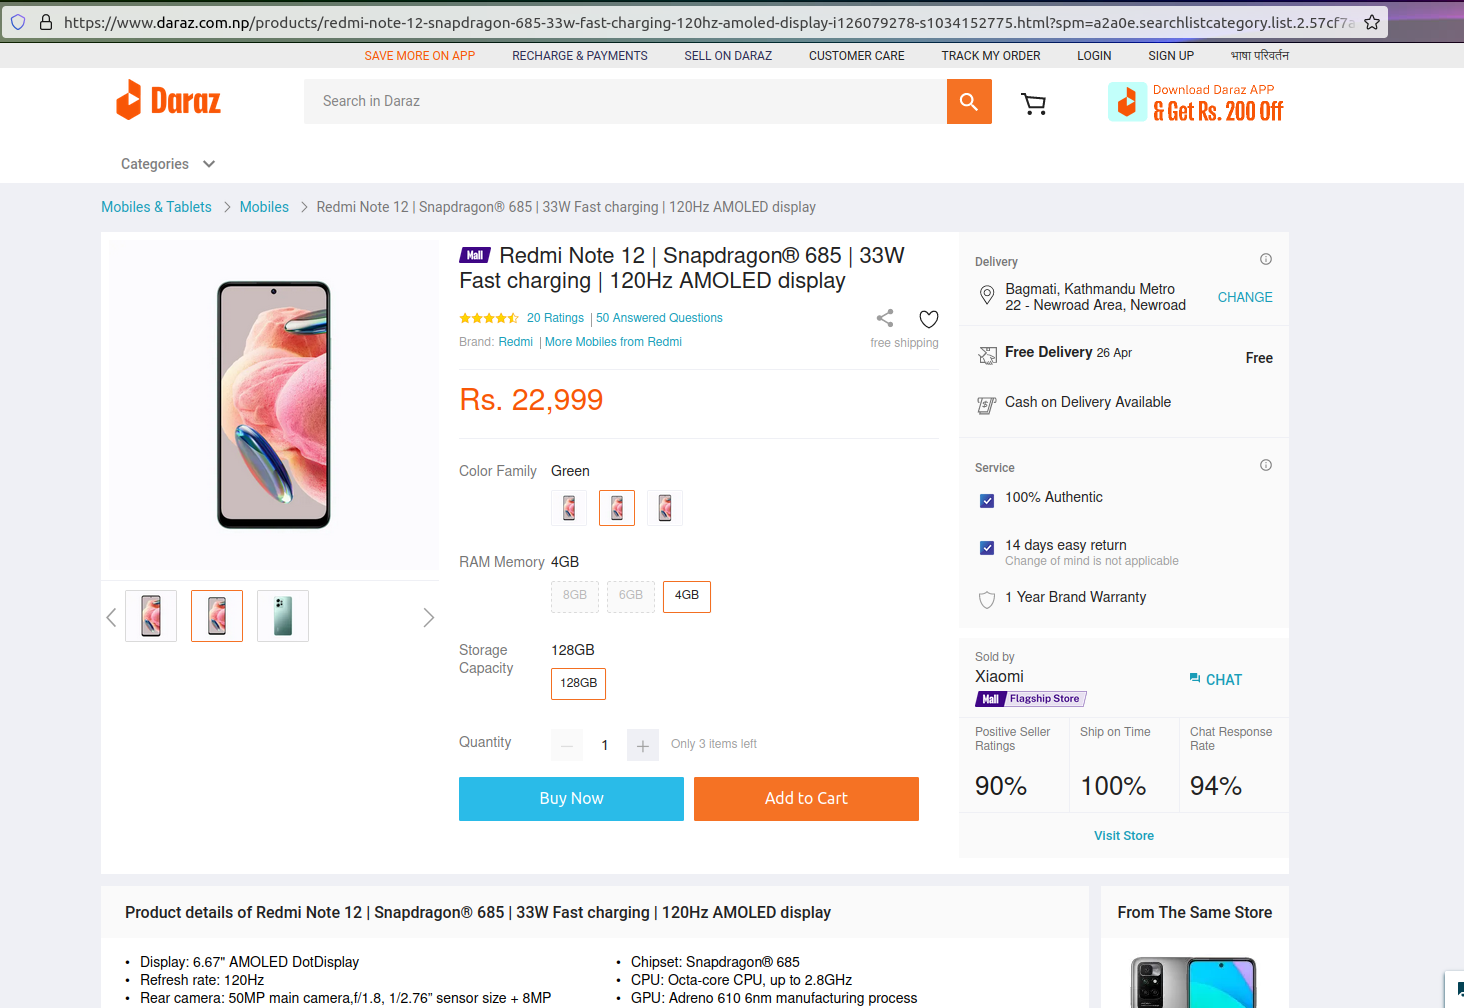

**figure: Screenshot of a product detail page**

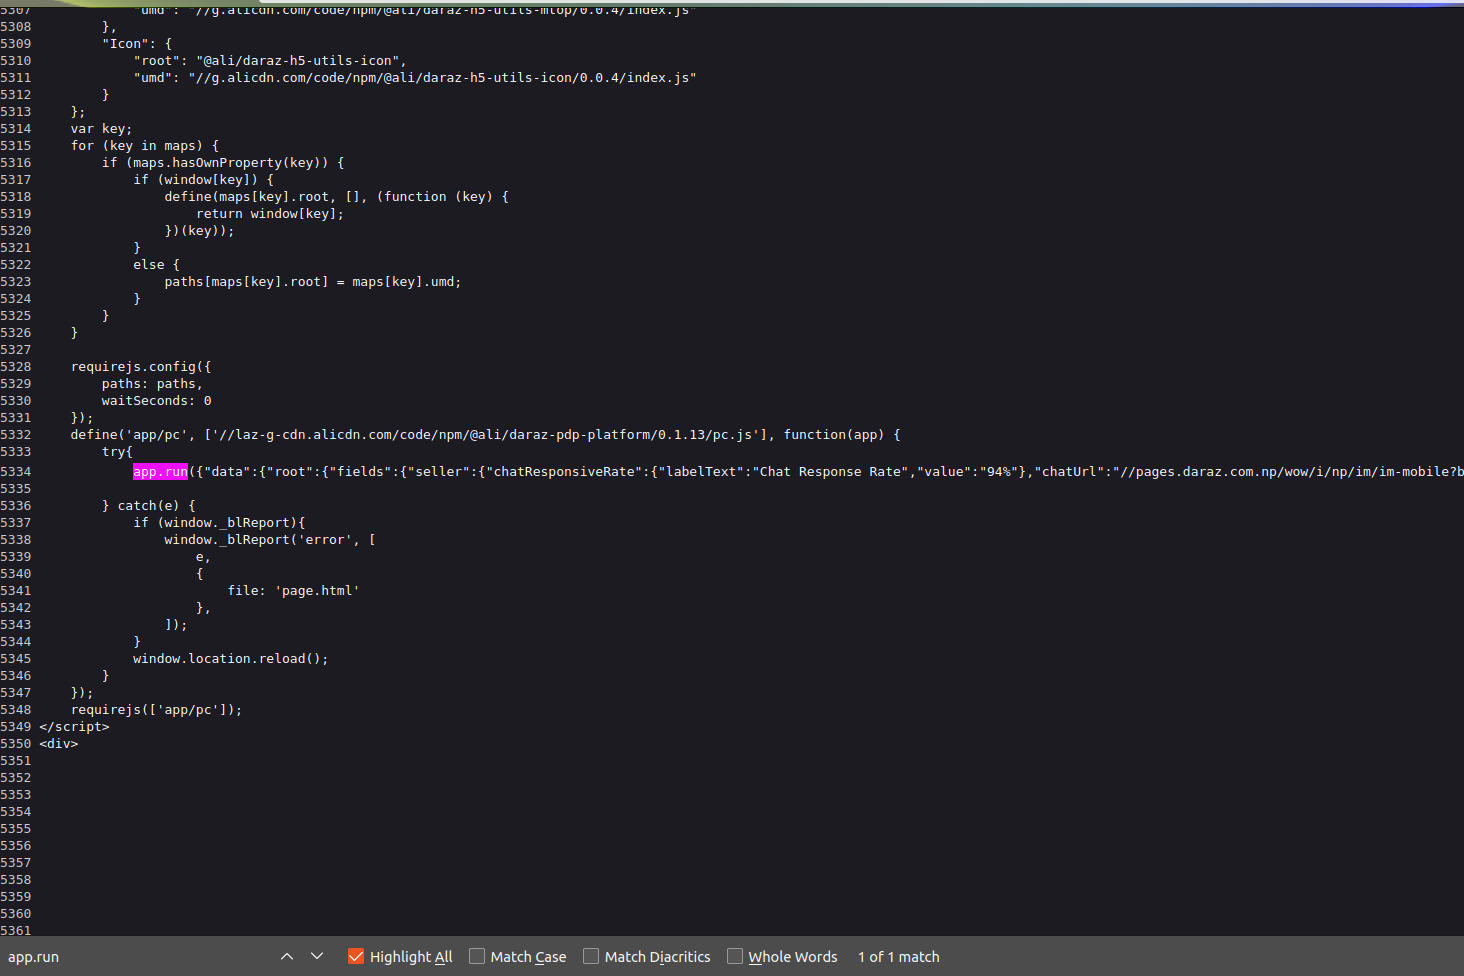
**figure: Source code of a product detail page highlighting where the json information is available**

In [59]:
def scrape_json_segment(url, pattern):
    '''
        it downloads the web page specified by the given url 
        and extracts the json segment from the html doc specifed by the regex pattern; 
        in nutshell, it basically scrap the certain segment from the web page
        
        args:
            url: string, URL of the target web page
            pattern: regex pattern of the json string segment
        returns:
            responses: python dictionary transform from the json
        
    '''
    response = requests.get(url, allow_redirects=False)
    if response.status_code != 200:
        return None
    matches = re.search(pattern, response.text)
    response_json_string = matches.groups(1)[0]
    responses = json.loads(response_json_string)
    return responses

In [60]:
# def filter_product_detail_link(product):
#     return 'https:'+product['productUrl']

def parse_skubase_properties(skubase_properties):
    result = {}
    for prop in skubase_properties:
        result[prop['pid']] = {'name': prop['name']}
        result[prop['pid']].update({
            'values': [{'vname': value['name'], 'vid': value['vid']} for value in prop['values']]
        })
    return result

def parse_product_prices(skuinfos):
    result = {}
    for sku_id, prod in skuinfos.items():
        result[sku_id] = prod['price']
    return result

def str_to_tuple(string):
    items = string.split(';')
    tuples = tuple([item.split(':') for item in items])
    return tuples

def create_mapper(sku_list):
    mapper ={}
    for sku in sku_list:
        if sku.get('propPath'):
            key = sku['innerSkuId'].split('-')[1]
            mapper[key] = str_to_tuple(sku['propPath'])
    return mapper

def search_value(values, key):
    for value in values:
        if value['vid'] == key:
            return value['vname']
    return None

def prepare_prop_and_price(mapper, prices, props):
    result = []
    for k, v in mapper.items():
        temp = {'price_info': prices[k]}
        filtered_props = {}
        for item in v:
            filtered_props[props[item[0]]['name']]=search_value(props[item[0]]['values'], item[1])
        temp.update({'props': filtered_props})
        result.append(temp)
    return result

def scrape_product_details(url):
    pattern = "app.run\((.*)\)" 
    product_details = {}
    try:
        product_json = scrape_json_segment(url, pattern)
        product_field = product_json['data']['root']['fields']
        product_details = list(product_field['specifications'].values())[0]['features']
        product_props = parse_skubase_properties(product_field['productOption']['skuBase']['properties'])
        #extract prices
        product_prices = parse_product_prices(product_field['skuInfos'])

        # map prices with product_props
        mapper = create_mapper(product_field['productOption']['skuBase']['skus'])
        prop_and_prices  = prepare_prop_and_price(mapper, product_prices, product_props)
        product_details.update({'price_n_prop':prop_and_prices})
        
    except Exception as e:
        print(e)
        print("!!!!!server error!!!!")
        pass
    
    return product_details

# <a name="run_concurrently"></a> Run Scraper Concurrently

Concurrent programming is a programming paradigm where a program is designed to execute multiple tasks simultaneously. This means that different parts of the program can run concurrently, or at the same time, without waiting for each other to complete.

In terms of web scraping, concurrent programming can be used to improve the efficiency and speed of the scraping process. Web scraping involves extracting data from websites, often by making multiple HTTP requests to fetch different pages or parts of pages. By using concurrent programming techniques, it's possible to make these requests simultaneously, rather than waiting for each one to complete before starting the next.

In [61]:
import random

In [62]:
def create_session():
    '''
        helps to create and configure session
        
        returns:
            session: requests.sessions.Session type 
    '''
#   global session
    session = requests.Session()
    
    headers = {
        "cookie": "JSESSIONID=6F1FD21F8D2B13569850AD0101EDBD58",
        "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/111.0",
        "Accept": "*/*",
        "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate, br",
        "Referer": "https://www.daraz.com.np/smartphones/?page=1",
        "Content-Type": "application/json",
        "Sec-Fetch-Dest": "empty",
        "Sec-Fetch-Mode": "cors",
        "Sec-Fetch-Site": "same-origin",
        "Connection": "keep-alive",
        "Cookie": "lzd_cid=c6029f3e-cd34-4e19-f1af-195ba8552605; t_uid=c6029f3e-cd34-4e19-f1af-195ba8552605; lwrid=AQGHdIR43CSKAbpxFknue1x29BP7; isg=BMrKo5KNmkMilRaf4_hik5lGGLlsu04VSN5_WVQDRZ3zB2vBPE6VJDNxF-vb7Mat; tfstk=cWn1BFsoR8VU1VNFl59EAzE-_MrVZYB7hFNiCCkVmqWRboMCi2jzNl3rosE4HJ1..; l=fBjBW6RgNM3LG-86BOfChurza779vIObYuPzaNbMi9fP_eCHIbfPW1NreaYMCn6NEsSXR3z5ep8DBzLuNy4kh2XDzYYZz2cQwdTHR3zQR; hng=NP|en-NP|NPR|524; userLanguageML=en-NP; _m_h5_tk=58e9589aff41803753c08c2392b19999_1682333935682; _m_h5_tk_enc=ba5a8e115d951a63f72222597f7f8430; _bl_uid=IhlR8gFFdz9eaRwakpI6qdmjdjjp; t_fv=1681297233353; cna=UX29HM3HX0MCAaM1GZsMHaMi; _gcl_au=1.1.79659918.1681297234; _ga=GA1.3.1396419356.1681297234; _ga_GEHLHHEXPG=GS1.1.1682326015.23.1.1682330163.0.0.0; cto_bundle=a8k4hV9jSWJXQzNDOEw0Yk1lMmhRTTclMkZOd1pTdElSViUyRmJhY2lrJTJGeVpYWGl2T2o3QmtFTWY1UWRZJTJGMCUyRm52UWswRFp3ZjU3OVdPVG96S1JNcU9NcHdyNHJBdWRGWGtaJTJCY0ttJTJGMnlPSFNXdE5qM0NHY25wbGx4cSUyQklpTmNvJTJCcSUyQlA4RXV0; lzd_sid=1053f79ea4b910990924e27056588160; _tb_token_=3e1e75d3e1e8b; curTraffic=lazada; JSESSIONID=719417B681AD0844501825EC7DE0D0B0; XSRF-TOKEN=b017b01c-a727-47dd-a4a6-e898ab83ef35; xlly_s=1; _gid=GA1.3.1018908048.1682304506; t_sid=Fb6ybTl96hGc0nwHfNk2osaic3cUcPWa; utm_channel=NA; daraz-marketing-tracker=hide; _gat_UA-98188874-1=1",
        "TE": "trailers"
    }


    session.headers.update(headers)
    
    retry = Retry(connect=4, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    return session


def scrape_multi_page(f_url, last_page, concurrency=True, shuffle=True):
    '''
        it takes f_url to and last_page to prepare url_lists, those url will be scraped
        
        args:
            f_url: url in the form of formated string
            last_page: integer value of the last_page upto where scraping will be done
            concurrency: boolean, if true scraping will be done concurrently else one page at a time
            shuffle: boolean, whether to shuffle the URL list before scraping or not
        returns:
            responses : generatory type (if concurrency is True) else list type
    '''
    urls_list = []
    #prepare links of every pages
    for i in range(1, last_page+1):
        urls_list.append(f_url.format(i))
    
    if shuffle:
        random.shuffle(urls_list)
    
    # prepare session
    global session
    session = create_session()
    
    if concurrency:
        with ThreadPoolExecutor(max_workers=5) as executor:
            responses=executor.map(scrape_single_page, urls_list)
    else:
        responses = []
        for url in urls_list:
            responses.append(scrape_single_page(url))
    session.close()
    return responses

# <a name="run"></a> Run the scraper

In [63]:
f_url = "https://www.daraz.com.np/smartphones/?ajax=true&page={}"
last_page = 22

In [64]:
responses = scrape_multi_page(f_url, last_page)

******scraping:**** https://www.daraz.com.np/smartphones/?ajax=true&page=4
******scraping:**** https://www.daraz.com.np/smartphones/?ajax=true&page=11
******scraping:**** https://www.daraz.com.np/smartphones/?ajax=true&page=19
******scraping:**** https://www.daraz.com.np/smartphones/?ajax=true&page=14
******scraping:**** https://www.daraz.com.np/smartphones/?ajax=true&page=10
extracting products detail
product: https://www.daraz.com.np/products/realme-c33-mobile-phone-4gb64gb-50-mp-ai-camera-65-inches-ips-lcd-li-po-5000-mah-battery-i120167332-s1032822730.html?search=1
extracting products detail
product: https://www.daraz.com.np/products/realme-c33-mobile-phone-4gb64gb-50-mp-ai-camera-65-inches-ips-lcd-li-po-5000-mah-battery-i120167332-s1032822730.html?search=1
extracting products detail
product: https://www.daraz.com.np/products/realme-c33-mobile-phone-4gb64gb-50-mp-ai-camera-65-inches-ips-lcd-li-po-5000-mah-battery-i120167332-s1032822730.html?search=1
extracting products detail
produc

KeyboardInterrupt: 

# <a name="save"></a> Save data
let's save the data, thus we can use if for another task.

In [36]:
data = unwrap_generator(responses)

In [40]:
with open("daraz_scraped_data_v3.json", "w") as f:
    json.dump(data, f)

In [38]:
data[0]

{'name': 'realme 10 Pro Plus | 8GB RAM & 128GB ROM',
 'url': 'https://www.daraz.com.np/products/realme-10-pro-plus-8gb-ram-128gb-rom-i123076745-s1033443679.html?search=1',
 'rating': 0.0,
 'review': 0.0,
 'brand_name': 'RealMe',
 'brand_id': '202391',
 'seller_name': 'NS Traders Suppliers',
 'description': {'os': [['realme ui 4.0', 'based on android 13']],
  'rear camera': [['108mp prolight camera + 8mp ultra-wide angle camera +  2mp macro camera']]},
 'details': {'Brand': 'RealMe',
  'SKU': '123076745_NP-1033443679',
  'Battery Capacity': '4000 - 4999 mAh',
  'Screen Size (inches)': '6.6 - 7 Inch',
  'Build Type': 'Not Specified',
  'Camera Front (Megapixels)': '16MP',
  'Camera Back (Megapixels)': '108MP+8MP+2MP',
  'Number Of Cameras': '4',
  'Display Protection': 'Glass',
  'Model Year': '2022',
  'Network Connections': '4G,3G,2G,5G',
  'Fast Charging': '67W Supervooc Charge',
  'Wireless Charging': 'No',
  'Number of SIM Slots': '2',
  'Charger Type': 'Type-C',
  'Flash': 'Yes',
 

[bact to top](#top)